# Tutorial 2.4: Deriving the EOM of a 4DOF floating wind turbine
In this tutorial you will learn to derive the Equations of Motion of a floating offshore wind turbine. The tutorial is quite elaborate, but contains large portions of example code to fully understand so that it can be applied in other offshore application projects

<center><img src="../images/Module2/w2_t4_floatingturbine.png" width="400" /></center>

We will schematize the floating wind turbine as follows:
- A rigid body, assumed rectangular, for all floaters together
    - $L$ = 50 m, $B$ = 50m, $H$ = 10 m, average density $\rho$ = 500 kg/m3
    - With horizontal anchor stiffness of 10 MN/m, and no vertical/rotational anchor stiffness. The anchor is attatched at the centre of the floater.
    - With 3 DOF: surge, heave, roll
- A turbine point mass connected via a rigid beam (assumed of negligible mass) and a rotational spring
    - $L_{tower}$ = 200 m, $m_{turbine}$ = 12.000 kg
    - A rotational spring of stiffness 15 GNm/rad
    - Located at 3/4 from the left of the substructure.
- Loaded by
    - Wind
    - Waves

Assume seawater of $\rho_{water}$ = 1025 kg/m3. The full system is without damping.
We also assume small displacements. Additionally this means that the water forces are not dependent on the ship position in time.

<center><img src="../images/Module2/w2_t4_floatingturbine_sketch.png" width="400" /></center>

## Part 1: Kinematic equations

We first start by defining the variables.

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sympy import *

var("t x_s z_s phi_s phi_t")      
# x_s substructure surge, z_s heave, phi_s roll, phi_t tower angle (to vertical)
x_s = Function("x_s")(t)
z_s = Function("z_s")(t)
phi_s = Function("phi_s")(t)
phi_t = Function("phi_t")(t)


In [122]:
# Define the kinematic relations here

# contants needed
var("x_st z_st L_t")
# dx_st hotizontal distance substructure centre to tower base
# dz_st vertica distance, L_t tower length

# positions of nacelle
x_t = x_s + x_st*cos(phi_s) - z_st*sin(phi_s) - L_t*sin(phi_t)
z_t = z_s + x_st*sin(phi_s) + z_st*cos(phi_s) + L_t*cos(phi_t)

# for energy relations later
phi_st = phi_s - phi_t

The velocities can then be obtained using:

In [123]:
# Compute/define the velocities here
x_s_dot = diff(x_s, t)
z_s_dot = diff(z_s, t)
phi_s_dot = diff(phi_s, t)
x_t_dot = diff(x_t, t)
z_t_dot = diff(z_t, t)
phi_t_dot = diff(phi_t, t) # will not be sued for point masses
phi_st_dot = diff(phi_st, t) # velocity will not be used

## Part 2: Energy equations
### Kinetic energy:
There are 2 masses in this system. The substructure also has some rotational inertia.

In [124]:
var("rho_s B_s H_s W_s m_t")
# substructure density, breadth, height, width; turbine mass

# Define the kinetic energy here (T)
m_s = rho_s*B_s*H_s*W_s
J_s = 1/12*m_s*(B_s**2 + H_s**2)
T_s = 1/2*m_s*(x_s_dot**2 + z_s_dot**2) + 1/2*J_s*(phi_s_dot**2)
T_t = 1/2*m_t*(x_t_dot**2 + z_t_dot**2) + 1/2*0*(phi_t_dot**2) # point mass so J_t = 0
T = T_s+T_t

### Potential energy:

In [125]:
var("rho_w g kr_st k_h")
# water density, rotational spring stiffness
# Define the potential energy here (V)

k_s = B_s*W_s*rho_w

draft_s = (B_s*W_s*H_s*rho_s)/(B_s*W_s*rho_w)
KB_s = draft_s/2 # COB, due to constant shape
nabla_s = B_s*W_s*draft_s # Submerged volume, taken in neutral position
J_sub = 1/12*W_s*B_s**3
BM_s = J_sub/nabla_s
KG_s = H_s/2 # COG, due to uniform weight
GM_s = KB_s + BM_s - KG_s
kr_s = rho_w*g*nabla_s*GM_s # Nm/rad

V_s = m_s*g*z_s + 1/2*k_h*x_s**2 + 1/2*k_s*z_s**2 + 1/2*kr_s*phi_s**2
V_t = m_t*g*z_t + 1/2*kr_st*phi_st**2 # need relative angle for this spring
V = V_s + V_t

### Work by external force
The work done by an external force working in the horizontal directio. The forces act on block 1 and 2 respectively

In [126]:
F_wave = Function("F_wave")(t)
M_wave = Function("M_wave")(t)
F_wind = Function("F_wind")(t)

# Define your external work here (W)
W = F_wave*z_s + M_wave*phi_s + F_wind*x_t

## Step 3: Construct the Lagrangian

In [127]:
# Define your Lagrangian here (L)
L = T - V - W

## Step 4: Obtaining the EoM

In order to obtain the EoMs we have to take derivatives w.r.t. $x_1$ and its velocity, as well as $x_2$. 

In [128]:
# Compute the EOM here
EOM_x_s = diff( diff(L, x_s_dot), t) - diff(L, x_s)
EOM_z_s = diff( diff(L, z_s_dot), t) - diff(L, z_s)
EOM_phi_s = diff( diff(L, phi_s_dot), t) - diff(L, phi_s)
EOM_phi_t = diff( diff(L, phi_t_dot), t) - diff(L, phi_t)

The equations are nonlinear since they depend on the cosines and sindes of the angles. We want to obtain a linear function, so let's linearize. We consider a perturbation around the point we want to linearize. 

On a technical note: Using SymPy for function substitution can be tricky, hence we will use temporary symbols called `tmp` in order to do the substitution.

In [129]:
# dictionaries for substitution
var("x_s_0 x_s_epsilon")
tmp1_x_s = symbols("tmp1_x_s")
psi_x_s = Function("psi_x_s")(t) # perturbation function
tmp2_x_s = symbols("tmp2_x_s")

var("z_s_0 z_s_epsilon")
psi_z_s = Function("psi_z_s")(t) # perturbation function
tmp1_z_s = symbols("tmp1_z_s")
tmp2_z_s = symbols("tmp2_z_s")

var("phi_s_0 phi_s_epsilon")
psi_phi_s = Function("psi_phi_s")(t) # perturbation function
tmp1_phi_s = symbols("tmp1_phi_s")
tmp2_phi_s = symbols("tmp2_phi_s")

var("phi_t_0 phi_t_epsilon")
psi_phi_t = Function("psi_phi_t")(t) # perturbation function
tmp1_phi_t = symbols("tmp1_phi_t")
tmp2_phi_t = symbols("tmp2_phi_t")

subs1_dict = {x_s: tmp1_x_s, z_s: tmp1_z_s, phi_s: tmp1_phi_s, phi_t: tmp1_phi_t}
subs2_dict = {tmp1_x_s: x_s_0 + x_s_epsilon*psi_x_s,
              tmp1_z_s: z_s_0 + z_s_epsilon*psi_z_s,
              tmp1_phi_s: phi_s_0 + phi_s_epsilon*psi_phi_s,
              tmp1_phi_t: phi_t_0 + phi_t_epsilon*psi_phi_t}
subs3_dict = {diff(x_s, (t, 2)): tmp2_x_s, x_s: tmp1_x_s,
              diff(z_s, (t, 2)): tmp2_z_s, z_s: tmp1_z_s,
              diff(phi_s, (t, 2)): tmp2_phi_s, phi_s: tmp1_phi_s,
              diff(phi_t, (t, 2)): tmp2_phi_t, phi_t: tmp1_phi_t}
subs4_dict = {tmp2_x_s: diff(x_s_0 + x_s_epsilon*psi_x_s, (t, 2)), tmp1_x_s: x_s_0 + x_s_epsilon*psi_x_s,
              tmp2_z_s: diff(z_s_0 + z_s_epsilon*psi_z_s, (t, 2)), tmp1_z_s: z_s_0 + z_s_epsilon*psi_z_s,
              tmp2_phi_s: diff(phi_s_0 + phi_s_epsilon*psi_phi_s, (t, 2)), tmp1_phi_s: phi_s_0 + phi_s_epsilon*psi_phi_s,
              tmp2_phi_t: diff(phi_t_0 + phi_t_epsilon*psi_phi_t, (t, 2)), tmp1_phi_t: phi_t_0 + phi_t_epsilon*psi_phi_t}
epsilons_dict = {x_s_epsilon: 1, z_s_epsilon: 1, phi_s_epsilon: 1, phi_t_epsilon: 1}


startpos_dict = {x_s_0: 0, z_s_0: 0, phi_s_0: 0, phi_t_0: 0}

In [130]:
# x_s
EOM_psi_x_s = EOM_x_s.evalf(subs=subs1_dict)
EOM_psi_x_s = EOM_psi_x_s.evalf(subs=subs2_dict)
EOM_lin_x_s = series(EOM_psi_x_s, x_s_epsilon, n=2)

EOM_psi2_x_s = EOM_x_s.evalf(subs=subs3_dict)
EOM_psi2_x_s = EOM_psi2_x_s.evalf(subs=subs4_dict)
EOM_lin_x_s = series(EOM_psi2_x_s, x_s_epsilon, n=2)

EOM_lin_x_s = EOM_lin_x_s.removeO().evalf(subs=epsilons_dict)
EOM_lin_x_s_simplified = EOM_lin_x_s.evalf(subs=startpos_dict) # makes symbolic calcs easier
EOM_lin_x_s_iso = solve(EOM_lin_x_s_simplified, diff(psi_x_s, (t, 2)))

x_s_dotdot = EOM_lin_x_s_iso[0].evalf(subs=startpos_dict)

In [131]:
# z_s
EOM_psi_z_s = EOM_z_s.evalf(subs=subs1_dict)
EOM_psi_z_s = EOM_psi_z_s.evalf(subs=subs2_dict)
EOM_lin_z_s = series(EOM_psi_z_s, z_s_epsilon, n=2)

EOM_psi2_z_s = EOM_z_s.evalf(subs=subs3_dict)
EOM_psi2_z_s = EOM_psi2_z_s.evalf(subs=subs4_dict)
EOM_lin_z_s = series(EOM_psi2_z_s, z_s_epsilon, n=2)

EOM_lin_z_s = EOM_lin_z_s.removeO().evalf(subs=epsilons_dict)
EOM_lin_z_s_simplified = EOM_lin_z_s.evalf(subs=startpos_dict) # makes symbolic calcs easier
EOM_lin_z_s_iso = solve(EOM_lin_z_s_simplified, diff(psi_z_s, (t, 2)))

z_s_dotdot = EOM_lin_z_s_iso[0].evalf(subs=startpos_dict)

In [132]:
# phi_s

EOM_psi_phi_s = EOM_phi_s.evalf(subs=subs1_dict)
EOM_psi_phi_s = EOM_psi_phi_s.evalf(subs=subs2_dict)
EOM_lin_phi_s = series(EOM_psi_phi_s, phi_s_epsilon, n=2)

EOM_psi2_phi_s = EOM_phi_s.evalf(subs=subs3_dict)
EOM_psi2_phi_s = EOM_psi2_phi_s.evalf(subs=subs4_dict)
EOM_lin_phi_s = series(EOM_psi2_phi_s, phi_s_epsilon, n=2)

EOM_lin_phi_s = EOM_lin_phi_s.removeO().evalf(subs=epsilons_dict)
EOM_lin_phi_s_simplified = EOM_lin_phi_s.evalf(subs=startpos_dict) # makes symbolic calcs easier
EOM_lin_phi_s_iso = solve(EOM_lin_phi_s_simplified, diff(psi_phi_s, (t, 2)))

phi_s_dotdot = EOM_lin_phi_s_iso[0].evalf(subs=startpos_dict)

In [133]:
# phi_t

EOM_psi_phi_t = EOM_phi_t.evalf(subs=subs1_dict)
EOM_psi_phi_t = EOM_psi_phi_t.evalf(subs=subs2_dict)
EOM_lin_phi_t = series(EOM_psi_phi_t, phi_t_epsilon, n=2)

EOM_psi2_phi_t = EOM_phi_t.evalf(subs=subs3_dict)
EOM_psi2_phi_t = EOM_psi2_phi_t.evalf(subs=subs4_dict)
EOM_lin_phi_t = series(EOM_psi2_phi_t, phi_t_epsilon, n=2)

EOM_lin_phi_t = EOM_lin_phi_t.removeO().evalf(subs=epsilons_dict)
EOM_lin_phi_t_simplified = EOM_lin_phi_t.evalf(subs=startpos_dict) # makes symbolic calcs easier
EOM_lin_phi_t_iso = solve(EOM_lin_phi_t_simplified, diff(psi_phi_t, (t, 2)))

phi_t_dotdot = EOM_lin_phi_t_iso[0].evalf(subs=startpos_dict)

Now we isolate it for the acceleration. Then we convert the EOM to matrices for easier interpretation. 

In [134]:
var("acc1 acc2 acc3 acc4 vel1 vel2 vel3 vel4")

dict_values = { Derivative(psi_x_s, (t,2)): acc1,
                Derivative(psi_z_s, (t,2)): acc2,
                Derivative(psi_phi_s, (t,2)): acc3,
                Derivative(psi_phi_t, (t,2)): acc4,
                Derivative(psi_x_s, t): vel1,
                Derivative(psi_z_s, t): vel2,
                Derivative(psi_phi_s, t): vel3,
                Derivative(psi_phi_t, t): vel4}

EOM_1 = EOM_lin_x_s_simplified.evalf(subs=dict_values)
EOM_2 = EOM_lin_z_s_simplified.evalf(subs=dict_values)
EOM_3 = EOM_lin_phi_s_simplified.evalf(subs=dict_values)
EOM_4 = EOM_lin_phi_t_simplified.evalf(subs=dict_values)

MTRX = linear_eq_to_matrix([EOM_1, EOM_2, EOM_3, EOM_4],
                           [acc1, acc2, acc3, acc4])
# Note: The results per line are the same af from for example EOM_lin_phi_t_iso

M = MTRX[0]
F = MTRX[1]

In [135]:
M

Matrix([
[          1.0*B_s*H_s*W_s*rho_s + 1.0*m_t,                                        0,                                                                                                             -1.0*m_t*x_st*sin(psi_phi_s(t)) - 1.0*m_t*z_st*cos(psi_phi_s(t)),                                                                                                                                              -1.0*L_t*m_t*cos(psi_phi_t(t))],
[                                        0,          1.0*B_s*H_s*W_s*rho_s + 1.0*m_t,                                                                                                              1.0*m_t*x_st*cos(psi_phi_s(t)) - 1.0*m_t*z_st*sin(psi_phi_s(t)),                                                                                                                                              -1.0*L_t*m_t*sin(psi_phi_t(t))],
[-1.0*m_t*x_st*psi_phi_s(t) - 1.0*m_t*z_st, 1.0*m_t*x_st - 1.0*m_t*z_st*psi_phi_s(t),                                      

In [136]:
F

Matrix([
[                                                                                                                                                                                                                                                                                                                                                         -1.0*L_t*m_t*vel4**2*sin(psi_phi_t(t)) - 1.0*k_h*psi_x_s(t) + 1.0*m_t*vel3**2*x_st*cos(psi_phi_s(t)) - 1.0*m_t*vel3**2*z_st*sin(psi_phi_s(t)) - F_wind(t)],
[                                                                                                                                                                                                                                                                                                                 -B_s*H_s*W_s*g*rho_s - 1.0*B_s*W_s*rho_w*psi_z_s(t) + 1.0*L_t*m_t*vel4**2*cos(psi_phi_t(t)) - g*m_t + 1.0*m_t*vel3**2*x_st*sin(psi_phi_s(t)) + 1.0*m_t*vel3**2*z_st*cos(psi_phi_s(t)) -

As one can see, this system is already linearized. We can therefore immediately start solving the system. In case of a non-linear example, the linearization must be performed for each EOM separately.

## Step 4: Solve the equation

**For students looking for a challenge**

The student is invited to try and plot a 100s trace of the horizontal and vertical nacelle movement. All relevant info can be find in the previous tutorial on how to use solve_ivp for multiple DOF, and on how to plot the relevant output.
The floater is subjected to the following force (in MN):

$$ F_h(t) = 1.25 \cos(0.1 t) + 0.5 \cos(0.5 t - 0.75) + 0.1 \cos(1.3 t + 2.28) $$


*Hint*: Think about how the nacelle moves. Which DOF contribute to its movement? <br>
*Hint*: Looking at the force in 1 direction (for the horizontal DOF), which movements do you excpect? Are the DOF coupled? How could one see that in the DOF-matrices?

In practice an irregular wave consits of waves generated from a spectrum, each with their respective amplitude, frequency and/or phase difference. [More information is given here](w2_t5.ipynb). Ask yourself then: 
- Which forces act on the structure? 
- Assuming small deformations, how does a water wave result in a force and moment in time on the structure 
Think about wave potentials, their pressures, and integration over the area on which the water acts

In [149]:
# Filling in values

L = 50
B = 50
H = 10
rho_ship = 400
L_tower = 200
m_turbine = 12e3
k_r = 15e9
x_r = L/4 # Distance from centre of floater
z_r = H/2
rho_water = 1025
g_val = 9.81
k_anchor = 10e6

def F_h(t):
    return (1.25 * cos(0.1*t) + 0.5*cos(0.5*t - 0.75) + 0.1*cos(1.3*t + 2.28))*10e3

dict_fillin = {B_s: L, H_s:H, W_s:B, m_t: m_turbine, z_st: z_r, x_st: x_r,
               L_t: L_tower, rho_s: rho_ship, g: g_val, rho_w: rho_water,
               F_wind: 0, kr_st: k_r, M_wave: 0, k_h: k_anchor}

In [150]:
M_filled = M.evalf(subs=dict_fillin)
M_filled

Matrix([
[                      10012000.0,                               0,                                                                                             -150000.0*sin(psi_phi_s(t)) - 60000.0*cos(psi_phi_s(t)),                                                                                                                        -2400000.0*cos(psi_phi_t(t))],
[                               0,                      10012000.0,                                                                                             -60000.0*sin(psi_phi_s(t)) + 150000.0*cos(psi_phi_s(t)),                                                                                                                        -2400000.0*sin(psi_phi_t(t))],
[-150000.0*psi_phi_s(t) - 60000.0, 150000.0 - 60000.0*psi_phi_s(t),                                                                                                                                    2168841666.66667, 12000000.0*psi_phi_s(t)*sin(psi_phi_t(t)

In [151]:
F_filled = F.evalf(subs=dict_fillin)
F_filled

Matrix([
[                                                                                                                       -60000.0*vel3**2*sin(psi_phi_s(t)) + 150000.0*vel3**2*cos(psi_phi_s(t)) - 2400000.0*vel4**2*sin(psi_phi_t(t)) - 10000000.0*psi_x_s(t)],
[                                                                                                150000.0*vel3**2*sin(psi_phi_s(t)) + 60000.0*vel3**2*cos(psi_phi_s(t)) + 2400000.0*vel4**2*cos(psi_phi_t(t)) - F_wave(t) - 2562500.0*psi_z_s(t) - 98217720.0],
[30000000.0*vel4**2*psi_phi_s(t)*sin(psi_phi_t(t)) - 12000000.0*vel4**2*psi_phi_s(t)*cos(psi_phi_t(t)) + 12000000.0*vel4**2*sin(psi_phi_t(t)) + 30000000.0*vel4**2*cos(psi_phi_t(t)) - 19937435409.1463*psi_phi_s(t) + 15000000000.0*psi_phi_t(t) - 1471500.0],
[              -30000000.0*vel3**2*psi_phi_t(t)*sin(psi_phi_s(t)) - 12000000.0*vel3**2*psi_phi_t(t)*cos(psi_phi_s(t)) + 12000000.0*vel3**2*sin(psi_phi_s(t)) - 30000000.0*vel3**2*cos(psi_phi_s(t)) + 15000000000.0*psi_phi_s(t

In [156]:
# Initial conditions and solve_ivp
q0 = np.zeros(8)

def qdot(t,q):

    print(t)
    
    vt = q[int(len(q)/2):]

    F_x_s = F_h(t)

    dict_values = { psi_x_s: q[0], psi_z_s: q[1],psi_phi_s: q[2], psi_phi_t: q[3], 
                    vel1: q[4], vel2: q[4], vel3: q[6], vel4: q[7],
                    F_wave: F_x_s}  
    Mass_matr =  M_filled.evalf(subs=dict_values)
    Force_vect = F_filled.evalf(subs=dict_values)
    at = Mass_matr.inv()*Force_vect

    return list(vt) + list(np.transpose(at)[0])

sol = solve_ivp(fun=qdot,t_span=[0,100],y0=q0) # Takes around 6 minutes to run 100 seconds of simulation

0.0
1e-06
1.9999999999999998e-05
2.9999999999999997e-05
7.999999999999999e-05
8.888888888888888e-05
9.999999999999999e-05
9.999999999999999e-05
0.00030000000000000003
0.00039999999999999996
0.0009
0.0009888888888888888
0.0011
0.0011
0.0031000000000000003
0.0041
0.0091
0.00998888888888889
0.0111
0.0111
0.031100000000000003
0.0411
0.09110000000000001
0.09998888888888889
0.1111
0.1111
0.2717937663014319
0.35214064945214785
0.7538750652057277
0.8252945168952529
0.9145688315071595
0.9145688315071595
1.0726641368813385
1.151711789568428
1.5469500530038756
1.6172146331701773
1.7050453583780545
1.7050453583780545
1.022858173361082
1.077002844288043
1.3477261989228493
1.3958547953023703
1.4560155407767716
1.4560155407767716
1.564304882630694
1.6184495535576553
1.8891729081924613
1.9373015045719824
1.9974622500463837
1.9974622500463837
2.1058234275236174
2.1600040162622345
2.4309069599553195
2.479067483278534
2.539268137432553
2.539268137432553
2.0784767992021855
2.1189840737800862
2.32152044666

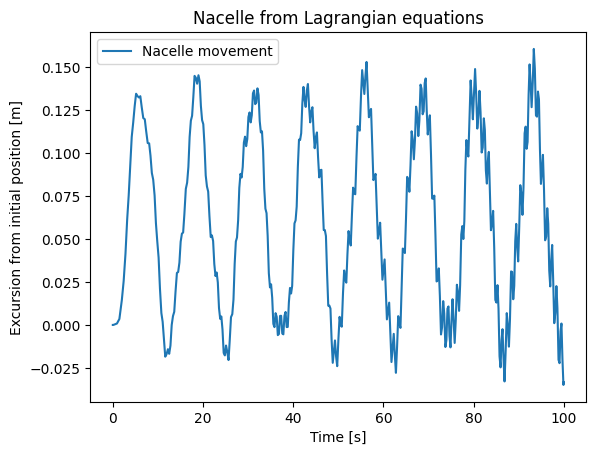

In [157]:
# Plot
# From earlier: x_t = x_s + x_st*cos(phi_s) - z_st*sin(phi_s) - L_t*sin(phi_t)
# To see changes: do -x_r
x_s = sol.y[0]
phi_s = sol.y[2]
phi_t = sol.y[3]
move_nacelle = x_s + x_r*np.cos(phi_s) - z_r*np.sin(phi_s) - L_tower*np.sin(phi_t) - x_r

plt.plot(sol.t,move_nacelle, label="Nacelle movement at 3 frequencies")
plt.xlabel("Time [s]")
plt.ylabel("Excursion from initial position [m]")
plt.title("Nacelle from Lagrangian equations")
plt.legend();